In [4]:
import numpy as np
import cv2
import glob

#Create function to load and rescale to 128x128 and greyscale
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)
    img = np.reshape(img, (128, 128))
    return img

# Create function to load the data
# [0] is the label // [1] is the image itself
def load_dataset(path):
    dataset = [(int(img_path[-6]), load_img(img_path)) for img_path in glob.glob(path)]
    return dataset

In [5]:
train_set = load_dataset('./train/*.png')
test_set = load_dataset('./test/*.png')

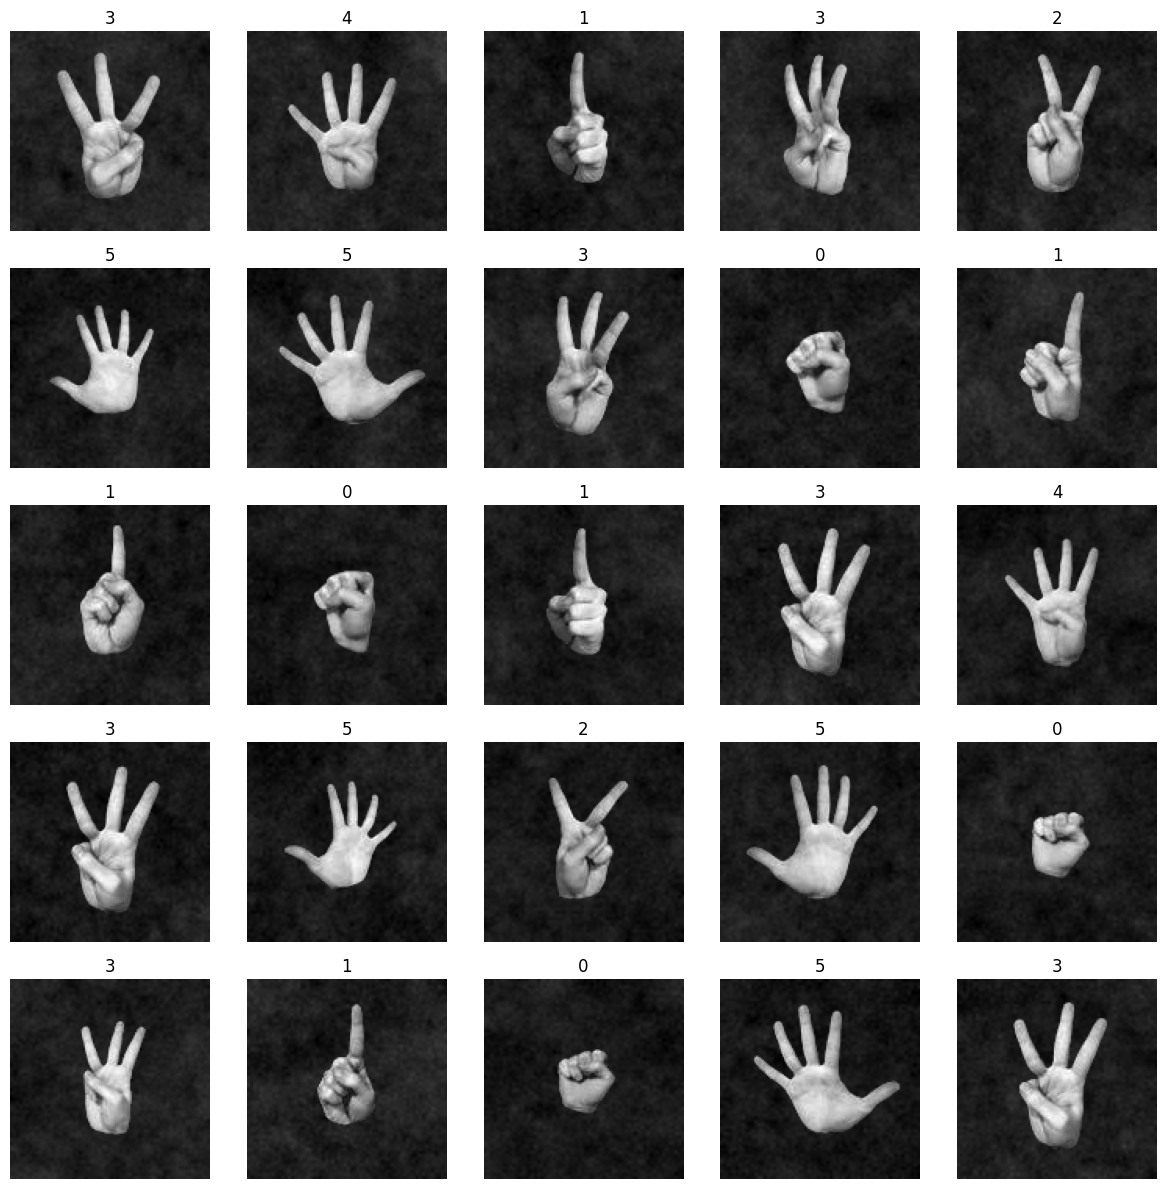

In [6]:
import matplotlib.pyplot as plt
import random

# Test To make sure the dataset has been created correctly and photos have the correct labels
grid_size = 5
_, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
axes = [y for x in axes for y in x]

for (i, (label, img)) in enumerate(random.sample(train_set, grid_size**2)):
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(label)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [1]:
# Process the actual photos
IMAGE_SIZE = 128

# Function to process each image by adding different filters and affects to make it the easiest fir the CNN to read
def process_image(img, thresh_low = 80, thresh_high = 255):
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))                         # Resize image to fixed size
    img = cv2.GaussianBlur(img, (5, 5), 0)                                  # Smooth image with Gaussian blur
    _, img = cv2.threshold(img, thresh_low, thresh_high, cv2.THRESH_BINARY) # Convert to black & white
    im_floodfill = img.copy()                                               # Copy image for flood fill operation
    h, w = img.shape[:2]                                                    # Get image height and width
    mask = np.zeros((h+2, w+2), np.uint8)                                   # Create mask for flood fill
    cv2.floodFill(im_floodfill, mask, (0,0), 255)                           # Fill background starting from top-left
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)                        # Invert flood-filled image
    img = img | im_floodfill_inv                                            # Combine to fill holes inside the finger
    img = img/255                                                           # Normalise pixel values (0–1)
    img = np.reshape(img, (IMAGE_SIZE, IMAGE_SIZE, 1))                      # Reshape to (size, size, 1) for CNN input
    return img

def process_dataset(dataset):
    dataset = [(label, process_image(img)) for (label, img) in dataset]
    return dataset

In [7]:
training_set = process_dataset(train_set)
test_set = process_dataset(test_set)

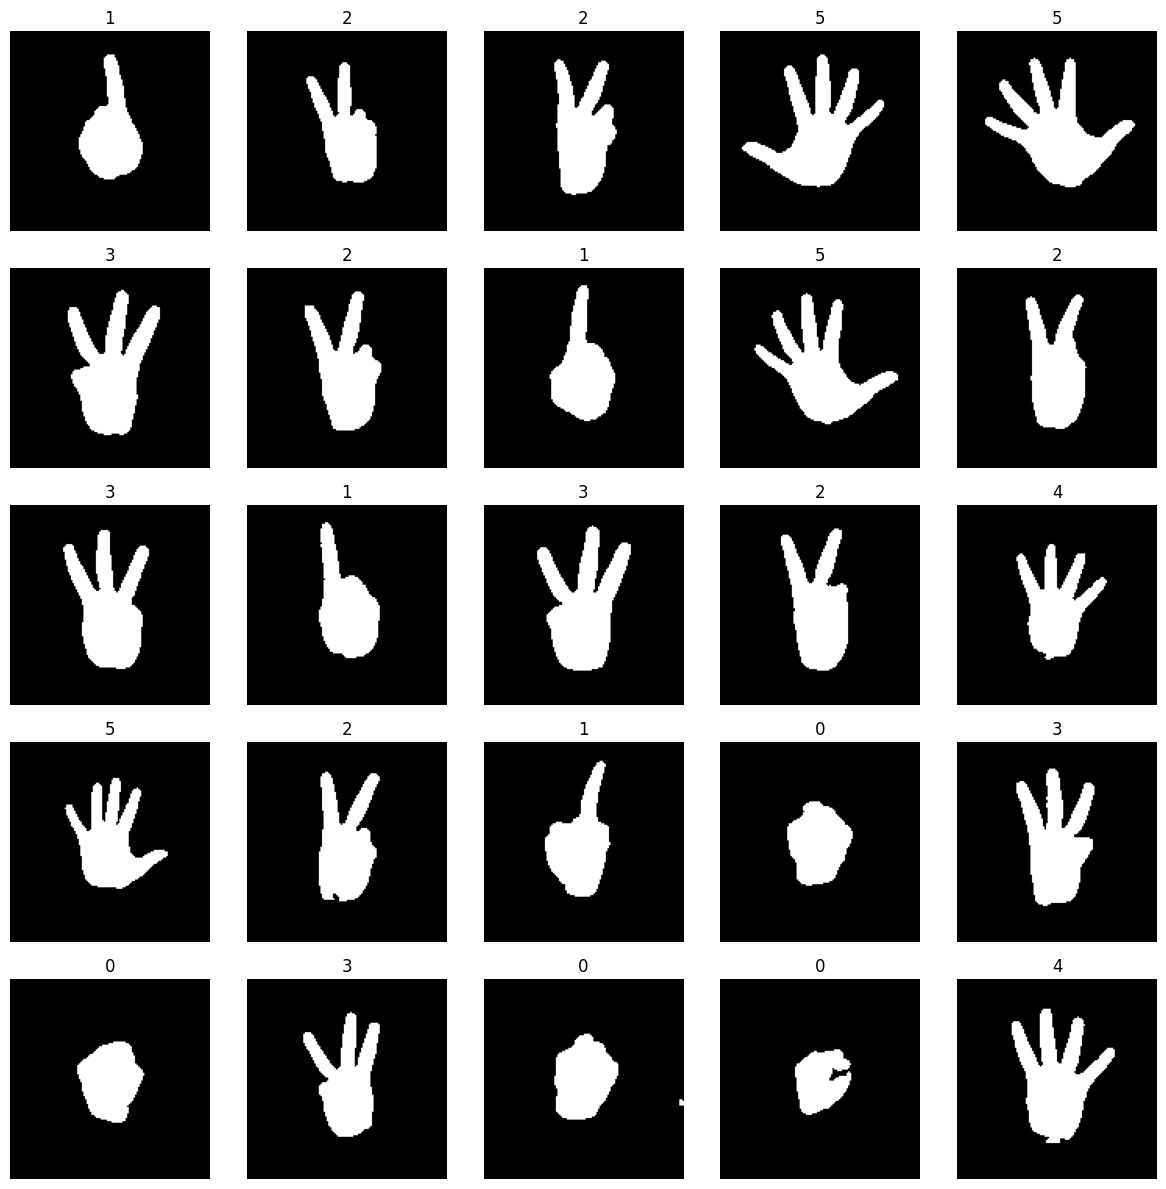

In [8]:
# Test to see if the images have changed
grid_size = 5
_, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
axes = [y for x in axes for y in x]

for (i, (label, img)) in enumerate(random.sample(training_set, grid_size**2)):
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(label)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [9]:
from tensorflow.keras.utils import to_categorical
import keras

# Splitting The Data into arrays that Keras can understand for training and testing
# Only takes the img from the training set
X_train = np.array([img for (_, img) in training_set])

# Encode the labels into 6 classes
# 0 = 0 fingers // 1 = 1 finger etc...
Y_train = to_categorical([label for (label, _) in training_set], num_classes = 6)

# Repeats for the test img and labels
X_test = np.array([img for (_, img) in test_set])
Y_test = to_categorical([label for (label, _) in test_set], num_classes = 6)

In [10]:
# Data Augmentation
# As real time inputs from video are going to have different lighting and shadows and angles i need to alter the images so it helps with generalization in real time at the cost of a slight decrease in accuracy while training
from keras.preprocessing.image import ImageDataGenerator

img_gen = ImageDataGenerator(
    rotation_range= 45,            # slight rotate up to 45 degrees (account for fingers at different angles other than centered)
    zoom_range = 0.2,              # 20% zoomed in/out (account for finger being close or further away)
    width_shift_range = 0.05,      # shifted on the vert or horz by 5% (account for hands not being near the center of thr screen)
    height_shift_range = 0.05,     # ^^^^^^^^^
    shear_range = 0.1,             # applies shear transformation, slanting the image (accounts for angle of hand)
    horizontal_flip = False,       # stops images from being flipped (prevent left hands and right hands flipping)
    fill_mode = "nearest"          # fills edges with the closest value to get smoother images
    )



In [15]:
# Creating The Model
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout
from keras.optimizers import Adam

def create_model():
    input_shape = [IMAGE_SIZE, IMAGE_SIZE, 1]   # 128x128 pixels, 1 channel = grayscale (3 would be RGB)
    KERNELS = (3, 3)
    STRIDES = (1, 1)

    model = Sequential([
        Input(shape = input_shape),

        Conv2D(32, KERNELS, strides = STRIDES, activation = "relu", padding = "same"),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Conv2D(64, KERNELS, strides = STRIDES, activation = "relu", padding = "same"),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Conv2D(128, KERNELS, strides = STRIDES, activation = "relu", padding = "same"),
        MaxPooling2D((2, 2)),
        BatchNormalization(),
        Dropout(0.3),

        # Flatten the 2D feature maps into a 1D vector
        Flatten(),

        # Dense output layer (6 = number of finger classes)
        Dense(6, activation="softmax"),
    ])

    # Compile the model with parameters
    model.compile(
        optimizer = Adam(learning_rate = 1e-3),
        loss = "categorical_crossentropy",
        metrics = ["accuracy"],
    )

    return model


In [16]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                      

In [25]:
# Model Training
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# mode -> tells keras that i am after low loss (if i was after big loss it would be max)

# Model Checkpoint: Saves the best model if it improves
model_checkpoint = ModelCheckpoint(
    "../Models/V2 Model.h5",               # File save location
    monitor = "loss",                   # Monitor the loss of the model
    verbose = 1,                        # Print a message when saving
    save_best_only = True,              # Only save if the model improves
    mode = "min",                       # "min" because the lower loss the better
)

# Early Stopping: Stops the model when it is no longer improving
early_stopping = EarlyStopping(
    monitor = "val_loss",               # Monitor the validation loss of the model
    verbose = 1,                        # Print a message when stopping
    min_delta = 0,                      # Minimum to be classed as improvement
    restore_best_weights = True,        # Restore the best waits after stopping
    patience = 3,                       # How many epochs to wait for improvement until stopping
    mode = "min",                       # Lower validation loss is better
)

# Reduce Learning Rate: Slows the learning rate down when no longer improving (Stops bigger unnecessary changes to weights and bias)
reduce_LR = ReduceLROnPlateau(
    monitor = "loss",                   # Monitor the loss of the model
    verbose = 1,                        # Print a message when slowing the LR
    factor = 0.5,                       # Reduce the LR by this factor
    patience = 1,                       # How many epochs to wait for no improvement before changing LR
    min_lr = 0.0001,                    # Do not reduce below this LR
    mode = "min",                       # Lower loss is better
)

In [27]:
# Training The Model
from scipy import ndimage

BATCH_SIZE = 32

model_history = model.fit(
    # Augmenting the images on the fly (.flow()) in batches of 32 when giving images and labels while training
    x = img_gen.flow(X_train, Y_train, batch_size = BATCH_SIZE),

    # Tells keras how many batches to process before counting up an epoch
    # (Divide total samples by batch size to get number of batches per epoch)
    steps_per_epoch = X_train.shape[0] // BATCH_SIZE,

    # Repeat Steps for validation data
    validation_data = img_gen.flow(X_test, Y_test, batch_size = BATCH_SIZE),
    validation_steps = X_test.shape[0] // BATCH_SIZE,

    epochs = 10,
    callbacks = [model_checkpoint, early_stopping, reduce_LR],
)

Epoch 1/10
562/562 [==============================] - ETA: 0s - loss: 0.0322 - accuracy: 0.9931
Epoch 1: loss improved from 0.06460 to 0.03224, saving model to Models\V2 Model.h5
562/562 [==============================] - 247s 439ms/step - loss: 0.0322 - accuracy: 0.9931 - val_loss: 0.0375 - val_accuracy: 0.9955 - lr: 5.0000e-04
Epoch 2/10
562/562 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 0.9911
Epoch 2: loss did not improve from 0.03224

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
562/562 [==============================] - 218s 387ms/step - loss: 0.0442 - accuracy: 0.9911 - val_loss: 0.0573 - val_accuracy: 0.9883 - lr: 5.0000e-04
Epoch 3/10
562/562 [==============================] - ETA: 0s - loss: 0.0185 - accuracy: 0.9953
Epoch 3: loss improved from 0.03224 to 0.01851, saving model to Models\V2 Model.h5
562/562 [==============================] - 207s 369ms/step - loss: 0.0185 - accuracy: 0.9953 - val_loss: 0.0251 - val_accu

In [28]:
# Evaluate on training set
scores = model.evaluate(X_train, Y_train)
print("Training Accuracy: %.2f%%" % (scores[1]*100))

# Evaluate on test set
scores = model.evaluate(X_test, Y_test)
print("Testing Accuracy: %.2f%%" % (scores[1]*100))


563/563 [==============================] - 56s 99ms/step - loss: 0.0016 - accuracy: 0.9998
Training Accuracy: 99.98%
113/113 [==============================] - 11s 99ms/step - loss: 0.0058 - accuracy: 0.9997
Testing Accuracy: 99.97%


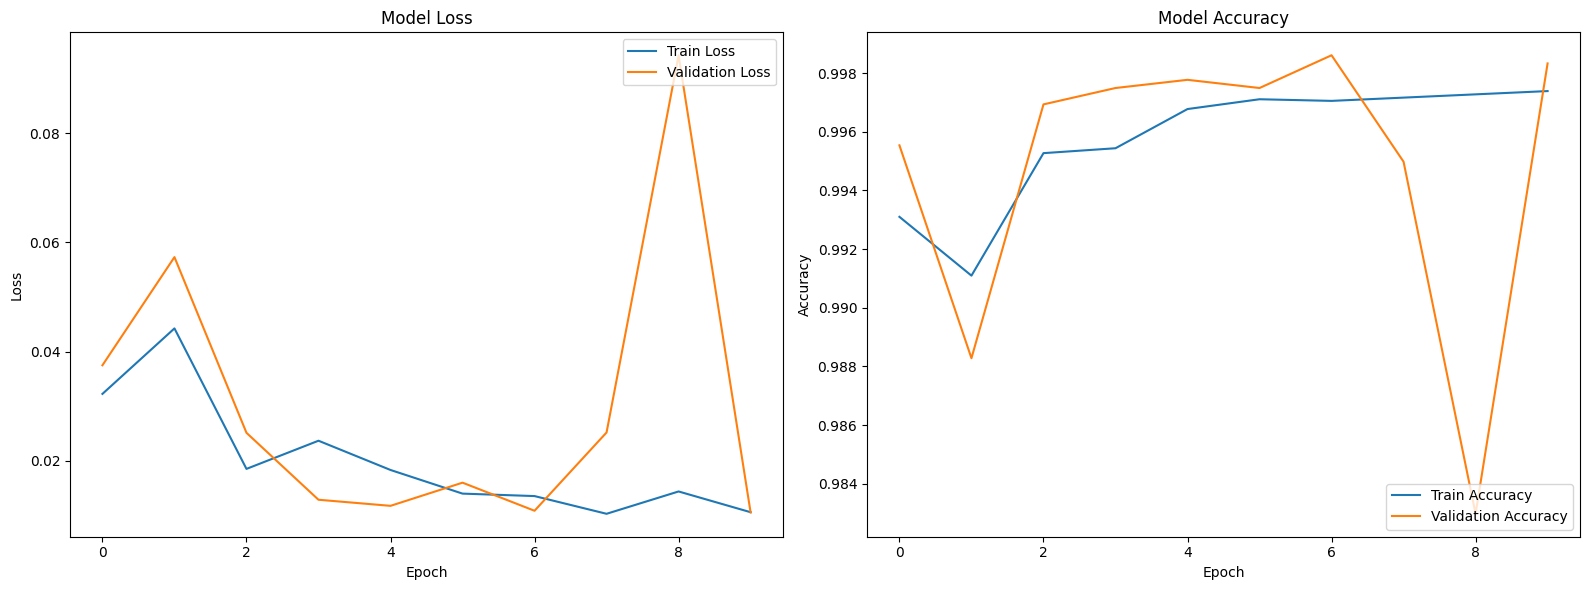

In [33]:
plt.figure(figsize=(16,6))

# Loss subplot
plt.subplot(1,2,1)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')

# Accuracy subplot
plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='lower right')

plt.tight_layout()
plt.show()
